## Assignment for Module 5, Training Models

In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [6]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [7]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [8]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [9]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# ASSIGNMENT

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=.3)

### Features

In [12]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [13]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.transform(X_tr)
X_te = poly.transform(X_te)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [15]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [18]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70549.62536236  69522.44448292  66640.43944345  68700.55956307]
Mean: 68853.2672129


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [19]:
lin_scores = cross_val_score(LinearRegression(), X_tr, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  2.28961612e+14   7.57419426e+05   6.09181669e+04   1.82025050e+15]
Mean: 5.12303027274e+14


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [20]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
67147.1090497


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [22]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_lr = GridSearchCV(Lasso(max_iter=5000), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_tr, y_tr)
print(grid_search_lr.best_params_)
print(np.sqrt(-grid_search_lr.best_score_))

{'alpha': 1000}
66596.6539789


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

In [23]:
from sklearn.linear_model import ElasticNet
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000], 'l1_ratio': [.3, .5, .7]}]
grid_search_en = GridSearchCV(ElasticNet(max_iter=5000), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_en.fit(X_tr, y_tr)
print(grid_search_en.best_params_)
print(np.sqrt(-grid_search_en.best_score_))

{'alpha': 0.1, 'l1_ratio': 0.3}
66992.0956835


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [24]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_en.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

66590.3677763


In [48]:
print('Mean train score: %s' % grid_search_en.cv_results_['mean_train_score'][grid_search_en.best_index_])
print('Mean test score: %s' % grid_search_en.cv_results_['mean_test_score'][grid_search_en.best_index_])

Mean train score: -4252436709.77
Mean test score: -4487940884.06


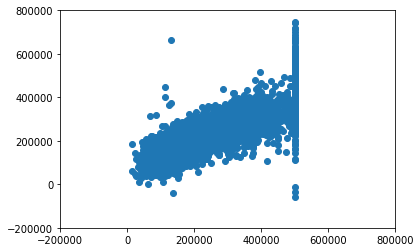

In [41]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te['median_house_value'].values, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

##### YOUR ANSWER HERE 

Looking at the training and testing scores for our best fit, both sets of error are within 10% of each other. This means that during cross-validation, our model was performing similarily on the training and test folds and not showing signs of high variance.

### [Optional] Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



The normal equation minimizes the MSE error which means minimizing each of these terms:

$\sum_{i=1}^m(\theta^T\cdot x^{(i)}-y^{(i)})^2$

To minimize this we take the derivative of the MSE function and set it to 0. This leads us to take the derivative of the equation above with respect to $\theta$ to find the $\theta$ that minimizes the equation. However, the dot product of $\theta^T\cdot x^{(i)}$ rotates the vector $x^{(i)}$ from a column to a row so when we take the derivative of this sum and aggregate the results back into matrix form, we have rotated $X$ to $X^T$ by this dot product.

### [Optional] Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?



No, this depends on the shape of the cost function and the learning rate. Not all cost functions are guaranteed to be universally convex, meaning that gradient descent could get stuck in a local minimum. Also, if the learning rate is chosen too high, then even with a convex cost function, the system may be unstable and oscillate.

### [Optional] Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?



Not necessarily. If the dollar cost for each execution run is very high then stopping immediately when the validation error goes up might be necessary but in most cases it is better to let the training run a little bit longer to ensure that the validation error really is moving up. This is because with small batches, and the random nature of some models, some noise in the performance metrics is expected and it is best to train a little bit longer so that we can be confident that the increase in validation error is signal and not noise.

### [Optional] Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?



If both training and validation errors are high it likely means our model does not have the capability to model the data (or that there is not really a signal in our data, but we'll ignore that for now). This means the model has high bias and we should try our model on a set of reduced regularization parameters.